### Trabalho de Redes Neurais com TensorFlow [22E3_2]

Professor: DSc. Diego Rodrigues

Aluno: Higor Souza Eller

##### Introdução

Trata-se do treinamento de uma rede neural que vai fornecer uma previsão de tempo resposta para um dado recurso em certas circunstâncias. A rede neural ajudaria na obtenção de uma estimativa de tempo para auxilar no empenho de alguma viatura para efetuar um atendimento de alguma natureza. O ciclo de desenvolvimento da solução seguiu a rotina CRISP.

##### Data understanding

Apesar do foco desta rede ser o tempo resposta de um atendimento, melhor seria se fosse o recurso. Prever qual recurso é o mais recomendado para dada ocorrência é mais útil, entretanto se trataria de um problema multiclasse com um número muito grande de classes. Por isso, os dados de tempo resposta foram categorizados em 6 categorias distintas, que são as classes de interesse do algoritmo em questão.

A base de dados inicial é composta por 822.000 ocorrências atendidas de 2018 até a data atual em 2022. Após os devidos tratamentos o número caiu para algo em torno de 430.000. As entradas são:

Entradas => ['rai',	'data',	'naturezas',	'bairro_cidade',	'recurso',	'tr',	'obm_escala',	'obm_afeto',	'qualificacao',	'sexo']

  - O número rai da ocorrência ("rai"), é uma espécie de ID da ocorrência gerado pelo sistema K9 da SSP.
  - A data ("data") do atendimento, consistindo em um registro de data e hora do acionamento.
  - A natureza do atendimento ("naturezas"). Por exemplo: ataque cardíaco, incêndio em galpão, tentativa de auto-extermínio etc.
  - A cidade e o bairro do atendimento ("bairro_cidade").
  - O tempo resposta ("tr"), o qual consiste no tempo entre o acionamento e o efetivo atendimento.
  - A Unidade Bombeiro Militar que realiza o atendimento ("obm_escala").
  - A Unidade Bombeiro Militar a qual a OBM está afeta, ou seja, a qual OBM ela responde ("obm_afeto")
  - A qualificação da vítima ("qualificacao"). Se é uma vítima comunicante, apenas um comunicante etc.
  - O sexo da vítima ("sexo"). Se é masculino, feminino ou não-informado.


Tipos de dados das entradas = {'rai' : 'int', 'data': 'timestamp', 'naturezas' : 'str', 'bairro_cidade' : 'str', 'recurso' : 'str', 'tr': 'datetime.time', 'obm_escala': 'str', 'obm_afeto': 'str', 'qualificacao': 'str', 'sexo': 'str'}

Saída => ["tempo_resposta"] => ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout
from joblib import dump, load
from matplotlib import pyplot
import tensorflow
import pandas
import numpy
import datetime
import seaborn
import itertools
import plotly.express as px

### Data preparation

1. Primeiramente os dados foram carregados em um dataframe.

2. As colunas "rai", "obm_afeto", "qualificacao" foram removidas pelo fato de não serem relevantes.

3. Os valores nulos foram removidos.

4. A data que originalmente era do tipo timestamp foi separada em duas colunas categóricas, "dia" e "periodo".

5. O tempo resposta foi categorizado para gerar as classes de saída ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo").

In [147]:
# DATA PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pandas.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1)

#REMOVING NULL VALUES
for column in df.columns:
    df.loc[pandas.isnull(df[column])]
    df = df.loc[df[column] != "(null)"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]


def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif 45 < total_time_in_minutes <= 80:
            return response_time_metric[5]
        elif total_time_in_minutes > 80:
            return "Drop"
        
        
#APPLYING
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING ROWS WITH MORE THAN 80 MINUTES RESPONSE TIME
df = df.loc[df["tempo_resposta"] != "Drop"]

#REMOVING "DATA" AND "TR" COLUMNS
df = df.drop(["data", "tr"], axis=1)

#REMOVING NONE VALUES
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df.head()

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.



naturezas  \
5  RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...   
6  RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...   
7  RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...   
8  RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...   
9  RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...   

              bairro_cidade recurso              obm_escala           sexo  \
5      ZONA RURAL - CATALÃO  UR-181       10º BBM - CATALÃO      MASCULINO   
6  ZONA RURAL - NOVA VENEZA  ABT-26                   CAEBM  NÃO-INFORMADO   
7  ZONA RURAL - NOVA VENEZA  ASA-74  1º BBM - SETOR CENTRAL  NÃO-INFORMADO   
8  ZONA RURAL - NOVA VENEZA  UR-211                   CAEBM  NÃO-INFORMADO   
9  ZONA RURAL - NOVA VENEZA  USA-21                     BSE  NÃO-INFORMADO   

       dia    periodo tempo_resposta  
5  Domingo  Madrugada   Muito rápido  
6  Domingo  Madrugada    Muito longo  
7  Domingo  Madrugada          Longo  
8  Domingo  Madrugada    Muito longo  
9  Domingo  Madrugada    Muito longo

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376873 entries, 5 to 822064
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   naturezas       376873 non-null  object
 1   bairro_cidade   376873 non-null  object
 2   recurso         376873 non-null  object
 3   obm_escala      376873 non-null  object
 4   sexo            376873 non-null  object
 5   dia             376873 non-null  object
 6   periodo         376873 non-null  object
 7   tempo_resposta  376873 non-null  object
dtypes: object(8)
memory usage: 25.9+ MB


Muito rápido          126041
Longo                  60794
Muito longo            50424
Extremamente longo     50058
Rápido                 47809
Médio                  41747
Name: tempo_resposta, dtype: int64


<AxesSubplot:title={'center':'Análise de desbalanceamento'}>

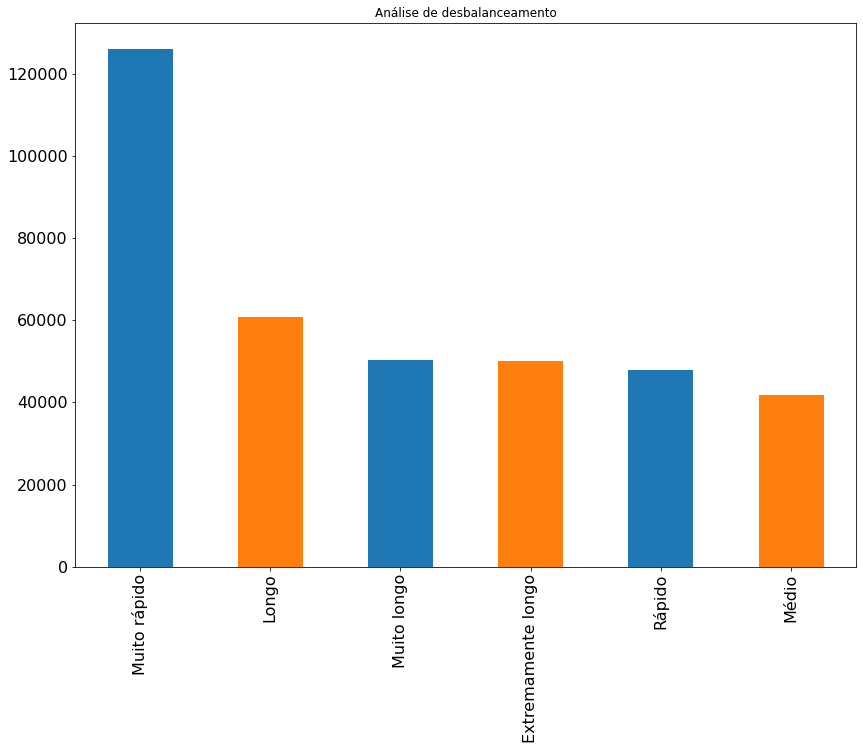

In [149]:
#SIMPLE IMBALANCE ANALYSIS
print(df["tempo_resposta"].value_counts())
target_count = df["tempo_resposta"].value_counts()
target_count.plot(kind='bar', title='Análise de desbalanceamento', figsize=(14,10), fontsize=16, color = ['#1F77B4', '#FF7F0E', '#1F77B4', '#FF7F0E', '#1F77B4', '#FF7F0E'])

In [150]:
def plot_column_distribution(df, column):
    """Plot the distribution of the column from dataframe"""
    
    column_val_df = df[column].value_counts().to_frame().reset_index()
    column_val_df.columns = [column, 'count']
    
    fig = px.bar(data_frame=column_val_df, x=column, y='count')
    fig.update_layout(
        autosize=True,
        height=600,
        hovermode='closest',
        showlegend=True,
        margin=dict(l=10, r=10, t=30, b=0)
    )
    
    fig.show()
    return None

plot_column_distribution(df, "tempo_resposta")

### Modeling

1. A função de ativação das camadas intermediárias que se mostrou mais performática foi a "relu" e para a camada de saída a função "softmax" foi utilizada.

2. A figura de mérito utilizada foi a "accuracy".

3. Apenas 3 "folds" foram escolhidos por questões de performance.

4. O número de neurônios de entrada foi calculado somando-se o número de classes possíveis com o número de colunas de entrada divido por 2 e arredondando para o maior inteiro.

5. O treinamento foi testado para os otimizadores "adam" e "SGD"

6. O número de neurônios de saída é igual ao número de classes possíveis.

7. A quantidade de camadas intermediárias foi obtida empiricamente.

8. O desbalanceamento foi contornado pela utilização de técnicas de "undersampling", pois devido ao grande volume de dados e a relativa proporção entre eles, a retirada de amostras se faz mais adequada do que a geração de amostras artificiais em um grande número.

In [151]:
#COOK PARAMETERS
class_col = 'tempo_resposta'
my_metric = 'accuracy'
random_seed = 33
n_k_folds = 3
my_patience = 40
my_epochs = 10 * my_patience
hidden_activation = 'relu'
activation_function = 'softmax'
hidden_neurons = 200
learning_rate = 0.0001
my_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
#my_optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
my_loss = 'categorical_crossentropy'
my_batch_size=100

In [152]:
print("GPU disponíveis: ", len(tensorflow.config.list_physical_devices('GPU')))

GPU disponíveis:  1


In [153]:
def prepareY(df):
    
    # EXTRACT Y AND DROP FROM DATAFRAME
    Y = df[class_col]

    # ENCODE CLASS VALUES AS INTEGERS
    yencoder = LabelEncoder()
    yencoder.fit(Y)
    return yencoder.transform(Y)

y = prepareY(df)
df = df.drop([class_col], axis=1)
pandas.DataFrame(y).head()

0
0  3
1  2
2  1
3  2
4  2

In [154]:
numerical_ix = df.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df.select_dtypes(include=['object', 'bool']).columns

In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

column_trans = ColumnTransformer(
     [('cat', OrdinalEncoder(),categorical_ix),
      ('num', MinMaxScaler(feature_range=(-1, 1)), numerical_ix)],
     remainder='drop')

column_trans.fit(df)
X = column_trans.transform(df)
pandas.DataFrame(X).head()

0       1      2     3    4    5    6
0  265.0  4574.0  483.0   2.0  1.0  0.0  0.0
1  207.0  4663.0   65.0  54.0  2.0  0.0  0.0
2  207.0  4663.0  233.0  23.0  2.0  0.0  0.0
3  207.0  4663.0  513.0  54.0  2.0  0.0  0.0
4  207.0  4663.0  621.0  53.0  2.0  0.0  0.0

In [156]:
# SCATTER PLOT
df_plot = pandas.DataFrame(X)
df_plot['Y'] = y

#g = seaborn.pairplot(df_plot, hue='Y', height=3, diag_kind='kde')
#_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [157]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_seed)

yhot = to_categorical(y_resampled)
yhot_train = to_categorical(y_train)
yhot_test = to_categorical(y_test)

In [158]:
#DEFINE MODEL
def baseline_model():
	# CREATE MODEL
	model = Sequential()
	# DEFINING HIDDEN LAYERS AND NEURONS
	model.add(Dense(16, input_dim=7, activation = hidden_activation))
	model.add(BatchNormalization())
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dense(hidden_neurons, activation = hidden_activation))
	model.add(Dropout(0.2))

	# DEFINING SOFTMAX FOR MULTI-CLASS CLASSIFICATION
	model.add(Dense(6, activation=activation_function))
	# COMPILE MODEL
	model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)
	return model

# MODEL = BASELINE_MODEL()
cmodel = KerasClassifier(build_fn=baseline_model, epochs=my_epochs, batch_size=my_batch_size, verbose=1)

In [159]:
#SETTING THE NUMBER OF FOLDS
kfold = KFold(n_splits=n_k_folds, shuffle=True)

In [160]:
with tensorflow.device('/gpu:0'):
    result = cross_val_score(cmodel, X_resampled, yhot, cv=kfold, verbose=1)
    print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/400
672/672 [==============================] - 13s 18ms/step - loss: 1.3681 - accuracy: 0.4462
Epoch 2/400
672/672 [==============================] - 12s 18ms/step - loss: 1.2019 - accuracy: 0.5178
Epoch 3/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1760 - accuracy: 0.5336
Epoch 4/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1735 - accuracy: 0.5361
Epoch 5/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1565 - accuracy: 0.5430
Epoch 6/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1510 - accuracy: 0.5490
Epoch 7/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1475 - accuracy: 0.5515
Epoch 8/400
672/672 [==============================] - 12s 18ms/step - loss: 1.1319 - accuracy: 0.5588
Epoch 9/400
672/672 [==============================] - 13s 19ms/step - loss: 1.1286 - accuracy: 0.5650
Epoch 10/400
672/672 [==============================] - 13s 19ms/step - l

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 248.6min finished


In [161]:
with tensorflow.device('/gpu:0'):
    model = baseline_model()
    model.compile(loss=my_loss, optimizer=my_optimizer, metrics=my_metric)

    history = model.fit(X_train, yhot_train, validation_split=0.3,
                        epochs=my_epochs, batch_size=my_batch_size, verbose=0)

### Evaluation

1. A avaliação do modelo foi realizada utilizando-se a figura de mérito da acurácia.

2. Foram plotados gráficos de linha comparando os dados do treino e os do teste para a acurácia e para a perda do modelo.

3. Foi plotada uma matriz confusão para a indicação de falsos positivos e falsos negativos e como as classes se confundem entre si no geral.

In [162]:
import matplotlib.pyplot as plt
# LIST ALL DATA IN HISTORY
print(history.history.keys())
# SUMMARIZE HISTORY FOR ACCURACY
val_metric_name = 'val_{}'.format(my_metric)
plt.figure(figsize=(20, 16), dpi=800)
plt.plot(history.history[my_metric])
plt.plot(history.history[val_metric_name])
plt.title('Model_{}'.format(my_metric))
plt.ylabel(my_metric)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# SUMMARIZE HISTORY FOR LOSS
plt.figure(figsize=(20, 16), dpi=800)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [163]:
# EVALUATE THE KERAS MODEL
from sklearn import metrics


_, accuracy = model.evaluate(X_test, yhot_test)
print('Accuracy from evaluate: %.2f' % (accuracy*100))

630/630 [==============================] - 6s 10ms/step - loss: 0.8430 - accuracy: 0.6938
Accuracy from evaluate: 69.38


In [164]:
# VERIFYING THE PREDICTION ACCURACY
predict_x = model.predict(X_test)
pred = numpy.argmax(predict_x, axis=1)
print(f'Prediction Accuracy: {(pred == y_test).mean() * 100:f}')

Prediction Accuracy: 69.375093


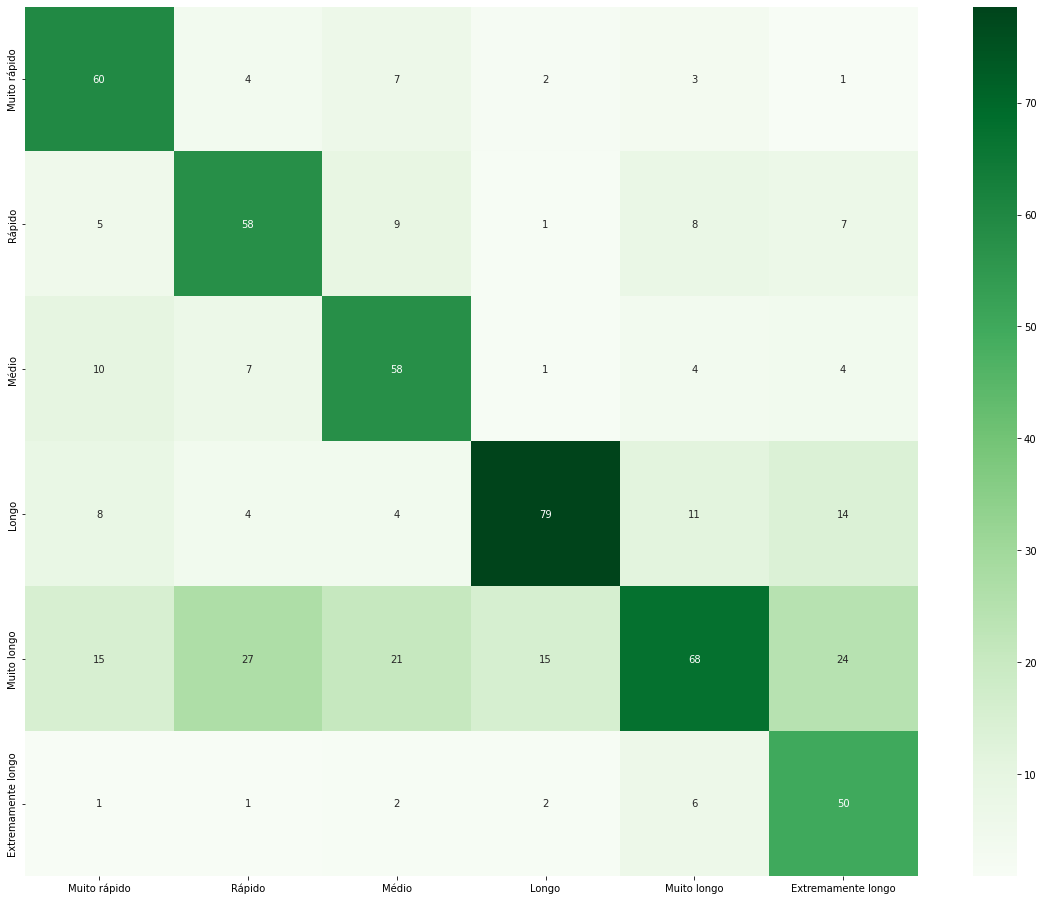

In [165]:
my_classes = ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]
df_Y_categorical = pandas.DataFrame(my_classes)

Y_est = model.predict(X_resampled)
Y_est_pred = numpy.argmax(Y_est, axis=1)

my_conf = confusion_matrix(y_resampled, Y_est_pred, labels=[0,1,2,3,4,5])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(20,16)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')

In [166]:
# COMPARISON WITH OTHER CLASSIFIERS - ONE AGAINST ALL
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


# ONE_VS_REST_CLASSIFIER + MLPCLASSIFIER STRATEGY
with tensorflow.device('/gpu:0'):
    mlp_classifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [100]*12))
    mlp_classifier.fit(numpy.array(X_train), y_train)
    dnns_predictions_labels = mlp_classifier.predict(X_test)
    
mlp_classifier_accuracy = metrics.accuracy_score(y_test, dnns_predictions_labels)

# LOGISTIC REGRESSION + OUTPUTCODECLASSIFIER STRATEGY
with tensorflow.device('/gpu:0'):
    logistic_regression_model = LogisticRegression(random_state=42)
    ecoc = OutputCodeClassifier(logistic_regression_model, code_size=15, random_state=42).fit(X_train, y_train)
    ecoc_predictions_labels = ecoc.predict(X_test)

ecoc_classifier_accuracy = metrics.accuracy_score(y_test, ecoc_predictions_labels)

# SVC STRATEGY
with tensorflow.device('/gpu:0'):
    svm_classifier = SVC(decision_function_shape='ovr')
    svm_classifier.fit(X_train, y_train)
    svm_predictions_labels = svm_classifier.predict(X_test)
    svm_classifier_accuracy = metrics.accuracy_score(y_test, svm_predictions_labels)

# ONE_VS_REST_CLASSIFIER + XGBCLASSIFIER STRATEGY
with tensorflow.device('/gpu:0'):
    xgb_classifier = OneVsRestClassifier(XGBClassifier())
    xgb_classifier.fit(numpy.array(X_train), y_train)
    xbg_predictions_labels = xgb_classifier.predict(X_test)

xgb_classifier_accuracy = metrics.accuracy_score(y_test, xbg_predictions_labels)

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (ma

[06:24:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:24:34] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:24:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:24:37] WARNING: /tmp/abs_40obctay9q/croots/recip

In [167]:
print(mlp_classifier_accuracy, ecoc_classifier_accuracy, svm_classifier_accuracy, xgb_classifier_accuracy)

0.6572194371370428 0.5081153521616122 0.5213679455998411 0.7727701394748597


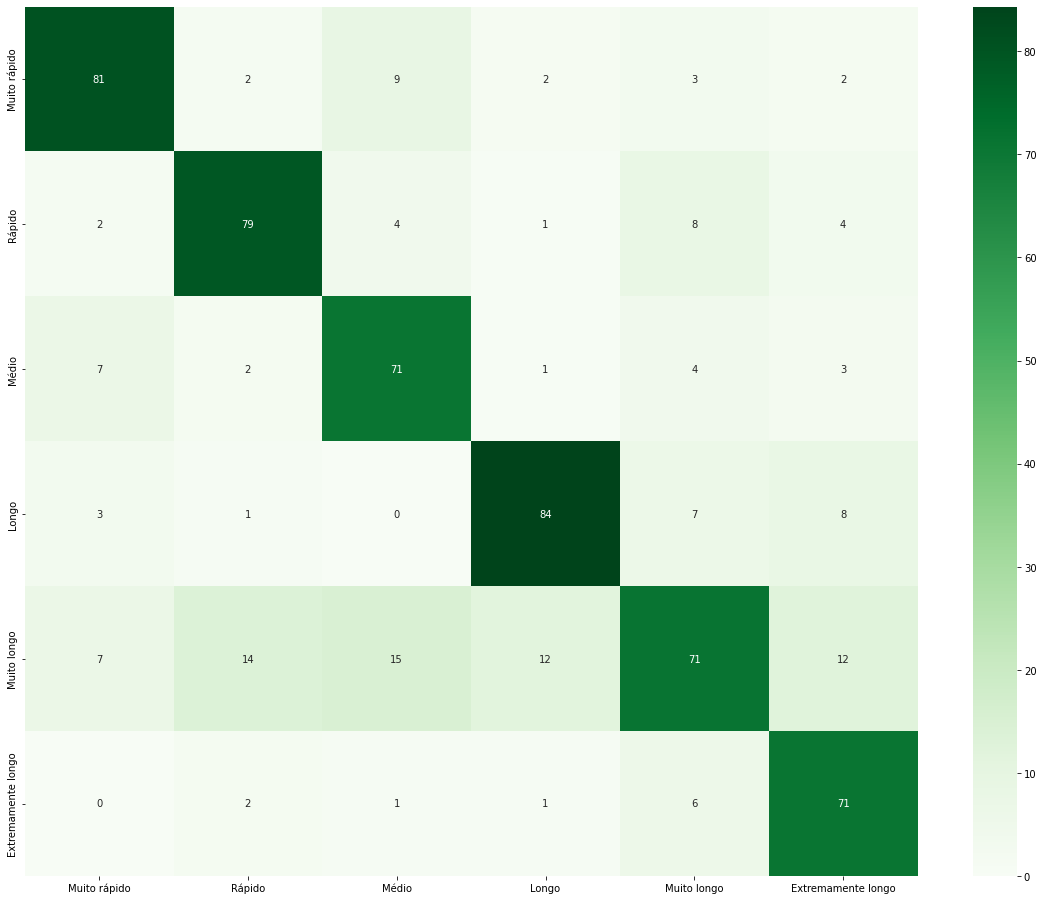

In [168]:
my_classes = ["Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo"]
df_Y_categorical = pandas.DataFrame(my_classes)

Y_est = xgb_classifier.predict(X_test)
Y_est_pred = numpy.argmax(Y_est, axis=0)

my_conf = confusion_matrix(y_test, Y_est, labels=[0,1,2,3,4,5])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(20,16)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')

In [169]:
#ENSEMBLE
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

with tensorflow.device('/gpu:0'):
    xgb_classifier_ensemble = OneVsRestClassifier(XGBClassifier())
    dnn_model = cmodel
    dnn_model._estimator_type = "classifier"
    intermediate = [('NN1', dnn_model)]
    dnn_xgb = StackingClassifier(estimators=intermediate, final_estimator=xgb_classifier_ensemble)
    history_dnn_xgb= dnn_xgb.fit(X_train, y_train)
    dnn_xgb_predictions = dnn_xgb.predict(X_test)
    dnn_xgb_accuracy = metrics.accuracy_score(y_test, dnn_xgb_predictions)

Epoch 1/400
806/806 [==============================] - 15s 18ms/step - loss: 1.2497 - accuracy: 0.4905
Epoch 2/400
806/806 [==============================] - 15s 19ms/step - loss: 1.1605 - accuracy: 0.5414
Epoch 3/400
806/806 [==============================] - 15s 19ms/step - loss: 1.1512 - accuracy: 0.5443
Epoch 4/400
806/806 [==============================] - 15s 18ms/step - loss: 1.1392 - accuracy: 0.5516
Epoch 5/400
806/806 [==============================] - 15s 18ms/step - loss: 1.1372 - accuracy: 0.5550
Epoch 6/400
806/806 [==============================] - 15s 18ms/step - loss: 1.1303 - accuracy: 0.5604
Epoch 7/400
806/806 [==============================] - 15s 19ms/step - loss: 1.1179 - accuracy: 0.5710
Epoch 8/400
806/806 [==============================] - 15s 18ms/step - loss: 1.1134 - accuracy: 0.5756
Epoch 9/400
806/806 [==============================] - 15s 18ms/step - loss: 1.1034 - accuracy: 0.5817
Epoch 10/400
806/806 [==============================] - 15s 18ms/step - l

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



162/162 [==============================] - 1s 5ms/step
Epoch 1/400
645/645 [==============================] - 12s 19ms/step - loss: 1.2775 - accuracy: 0.4555
Epoch 2/400
645/645 [==============================] - 12s 18ms/step - loss: 1.1834 - accuracy: 0.5304
Epoch 3/400
645/645 [==============================] - 12s 18ms/step - loss: 1.1678 - accuracy: 0.5386
Epoch 4/400
645/645 [==============================] - 12s 19ms/step - loss: 1.1665 - accuracy: 0.5382
Epoch 5/400
645/645 [==============================] - 12s 19ms/step - loss: 1.1623 - accuracy: 0.5383
Epoch 6/400
645/645 [==============================] - 12s 19ms/step - loss: 1.1589 - accuracy: 0.5421
Epoch 7/400
645/645 [==============================] - 12s 19ms/step - loss: 1.1592 - accuracy: 0.5440
Epoch 8/400
645/645 [==============================] - 12s 18ms/step - loss: 1.1455 - accuracy: 0.5548
Epoch 9/400
645/645 [==============================] - 12s 18ms/step - loss: 1.1383 - accuracy: 0.5611
Epoch 10/400
645/6

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[14:51:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:28] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:36] WARNING: /tmp/abs_40obctay9q/croots/recip

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning:

`model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.



202/202 [==============================] - 1s 6ms/step


In [175]:
clf_accuracy = metrics.accuracy_score(y_test, dnn_xgb_predictions)
clf_accuracy

0.7052166575668835

In [ ]:
#ENSEMBLE
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

with tensorflow.device('/gpu:0'):
    mlp_classifier_ensemble = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = [100]*12))
    dnn_model = cmodel
    dnn_model._estimator_type = "classifier"
    intermediate = [('NN1', dnn_model)]
    dnn_mlp = StackingClassifier(estimators=intermediate, final_estimator=mlp_classifier_ensemble)
    history_dnn_mlp = dnn_mlp.fit(X_train, y_train)
    dnn_mlp_predictions = dnn_mlp.predict(X_test)
    dnn_mlp_accuracy = metrics.accuracy_score(y_test, dnn_mlp_predictions)